In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [13]:
# Memuat dataset
data = pd.read_csv('weatherAUS.csv')

# Informasi dataset
print("Informasi Dataset:")
print(data.info())
print("\nStatistik Dataset:")
print(data.describe())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am  


Nilai Hilang per Kolom:
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


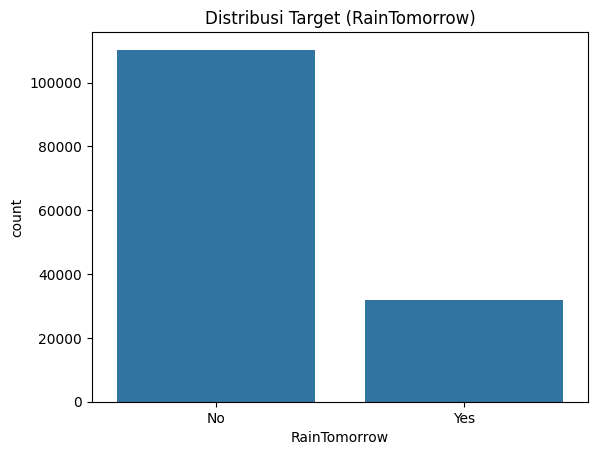

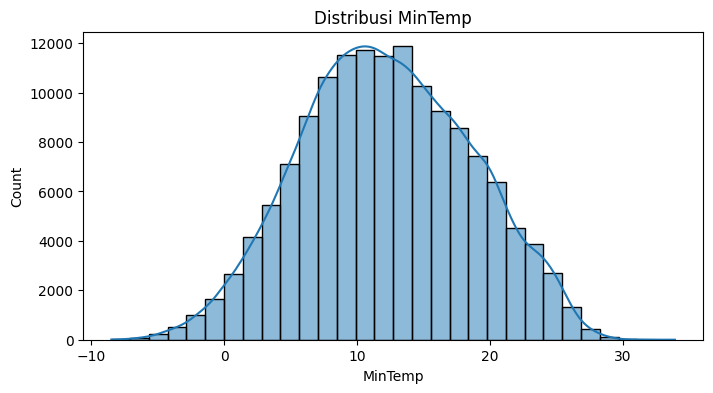

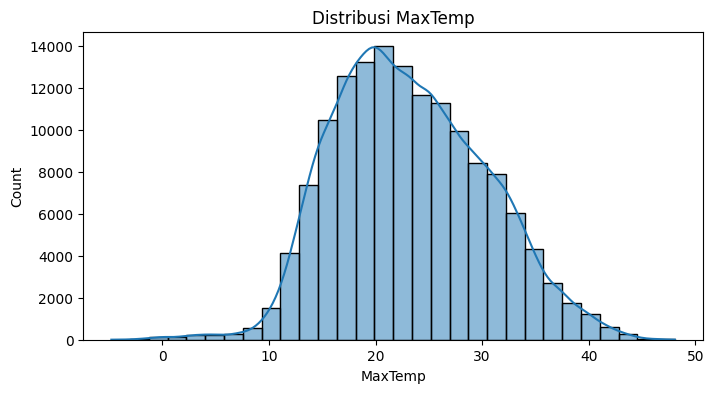

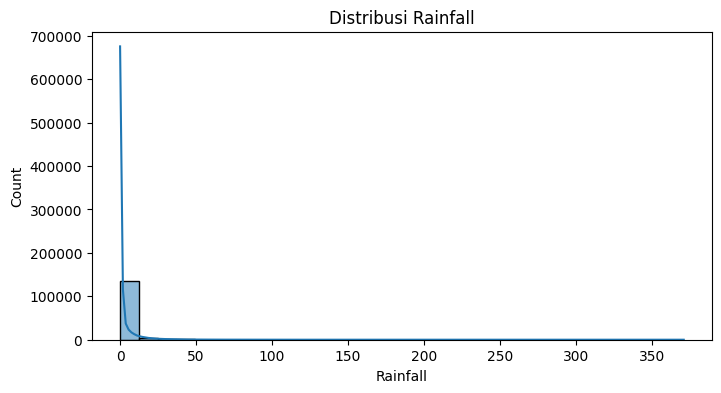

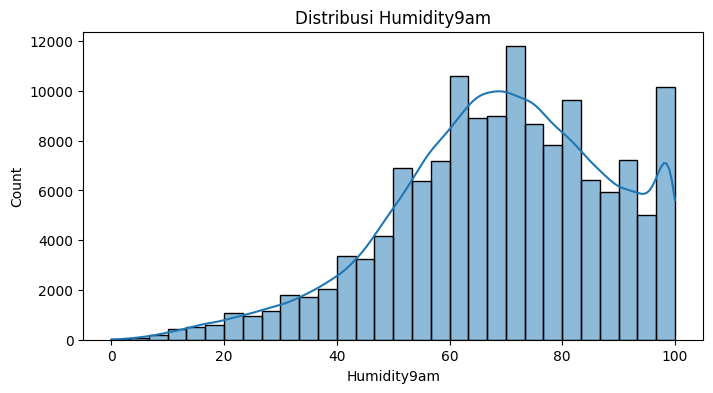

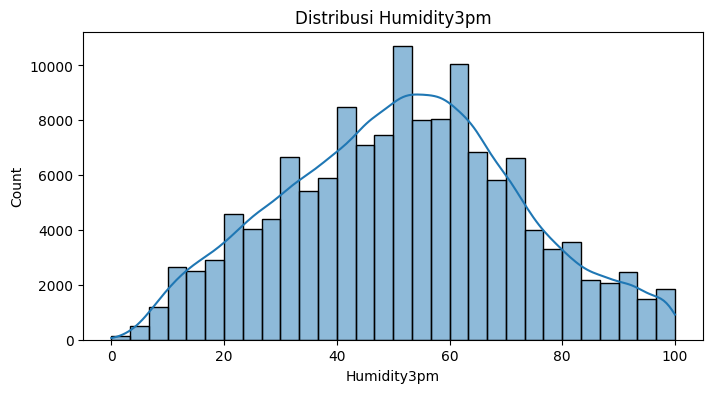

In [14]:
# Menampilkan nilai hilang
print("\nNilai Hilang per Kolom:")
print(data.isnull().sum())

# Distribusi target
sns.countplot(x='RainTomorrow', data=data)
plt.title('Distribusi Target (RainTomorrow)')
plt.show()


# Visualisasi distribusi fitur numerik
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Humidity3pm']
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribusi {feature}')
    plt.show()


In [15]:
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

C:\Users\BINTANGPRIMADATA\AppData\Local\Temp\ipykernel_19360\1229360362.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
C:\Users\BINTANGPRIMADATA\AppData\Local\Temp\ipykernel_19360\1229360362.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting',

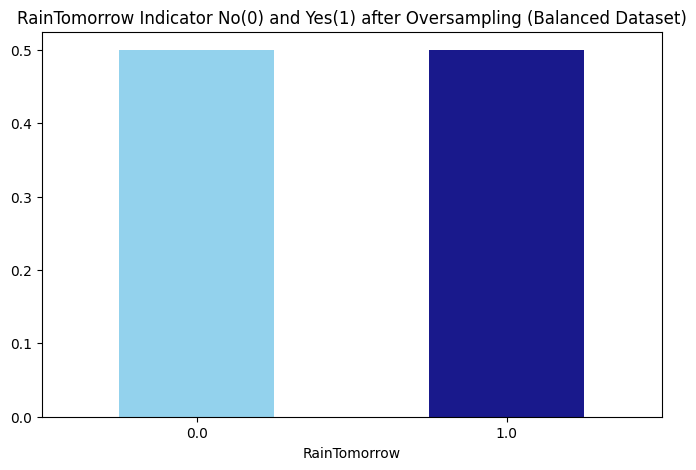

In [19]:
from sklearn.utils import resample

no = data[data.RainTomorrow == 0]
yes = data[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [20]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [21]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [22]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [23]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [24]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

c:\Users\BINTANGPRIMADATA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [25]:
MiceImputed.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,396,2,13.4,22.9,0.6,5.734653,7.446035,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.000000,4.848545,16.9,21.8,0.0,0.0
1,397,2,7.4,25.1,0.0,5.639329,11.520531,14,44.0,6,...,44.0,25.0,1010.6,1007.8,1.731945,2.625892,17.2,24.3,0.0,0.0
2,398,2,12.9,25.7,0.0,7.762688,12.348852,15,46.0,13,...,38.0,30.0,1007.6,1008.7,1.827673,2.000000,21.0,23.2,0.0,0.0
3,399,2,9.2,28.0,0.0,5.977293,11.811634,4,24.0,9,...,45.0,16.0,1017.6,1012.8,1.233996,2.116194,18.1,26.5,0.0,0.0
4,400,2,17.5,32.3,1.0,6.852837,5.728406,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0,0.0


In [26]:
MiceImputed.isna()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133585,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
87307,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
56427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [28]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

In [29]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [30]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [31]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [32]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [33]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [46]:
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    import time

    t0 = time.time()

    # Latih model
    if verbose:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, verbose=0)

    # Prediksi
    y_pred = model.predict(X_test)

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0

    # Hasil evaluasi
    print(f"Accuracy = {accuracy:.5f}")
    print(f"ROC Area under Curve = {roc_auc:.5f}")
    print(f"Cohen's Kappa = {coh_kap:.5f}")
    print(f"Time taken = {time_taken:.5f}")
    print(classification_report(y_test, y_pred, digits=5))

    # ROC Curve
    probs = model.predict_proba(X_test)[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fper, tper, label="ROC Curve", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="No Skill")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize="all")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return model, accuracy, roc_auc, coh_kap, time_taken


c:\Users\BINTANGPRIMADATA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy = 0.93370
ROC Area under Curve = 0.93822
Cohen's Kappa = 0.86694
Time taken = 5.08679
              precision    recall  f1-score   support

         0.0    0.97959   0.90029   0.93827     23879
         1.0    0.88510   0.97616   0.92840     18789

    accuracy                        0.93370     42668
   macro avg    0.93234   0.93822   0.93333     42668
weighted avg    0.93798   0.93370   0.93392     42668



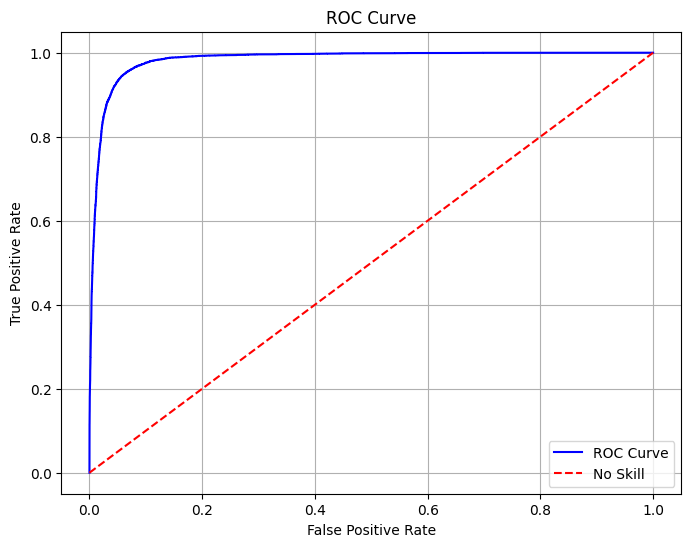

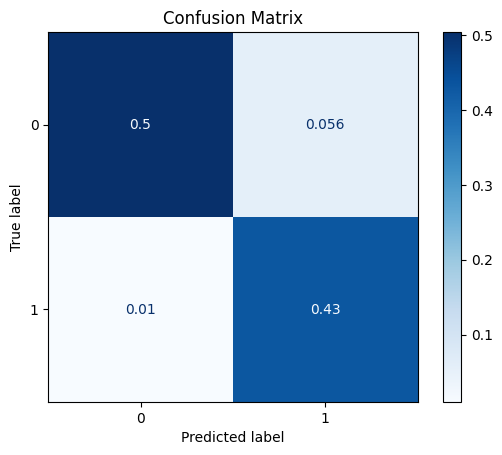

In [47]:
import xgboost as xgb

params_xgb = {
    'n_estimators': 500,
    'max_depth': 16,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

model_xgb = xgb.XGBClassifier(**params_xgb)

model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(
    model_xgb, X_train, y_train, X_test, y_test
)


In [48]:
import joblib

# Menyimpan model ke file .joblib
joblib.dump(model_xgb, 'xgboost_model.joblib')

# Menyimpan scaler untuk preprocessing
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [55]:
import joblib

# Menyimpan model dalam format .h5
joblib.dump(model_xgb, 'xgboost_model.h5')
# Memuat scaler
scaler_loaded = joblib.load('scaler.pkl')